### Imports

In [1]:
from os.path import abspath, join
import pandas as pd
import numpy as np
import re
from mizani.formatters import percent_format
from plotnine import ggplot, geom_bar, aes, scale_x_discrete, theme, element_text, labs, ylim,\
    scale_x_continuous, scale_y_continuous, geom_line, geom_boxplot,  xlim, facet_wrap, scale_fill_manual

### Global constants
Files and paths

In [2]:
base_dir = "C:/Nitsan/third/JavaAnalyzer"
analyzer_results_file = "analyzerResults_v2.csv"
external_words_file = "analyzerResults_words_ALL.csv"

Graphs parameters

In [3]:
fill='#5a9cd9'
log_x_scale_labels = ["1", "2-10", "11-100", "101-1000", "1001-10000", "10001-100000"]
font_size=16

Column headers

In [4]:
name_col = "name"
length_col = "length"
project_col = "project"
type_col = "className"
word_count_col = "wordCount"
count_col = "count"
freq_col = "frequency"
rank_col = "rank"

## Data load

In [5]:
df = pd.read_csv(abspath(join(base_dir, analyzer_results_file)))

## Data cleanup:
Remove type declarations:

In [6]:
df = df[~df[type_col].isin(["TypeParameter","ClassOrInterfaceType"])]

Remove external words:

In [7]:
external_tagging_data = pd.read_csv(abspath(join(base_dir, external_words_file)))
external_words = external_tagging_data[np.where(external_tagging_data['external'] == 1, True, False)]['word']
df= df[~df[name_col].isin(external_words)]

Removed words:

In [8]:
print(external_words)
print(str(len(external_words)) + " words removed")

0                          T
1                     String
3                          R
4                     Object
8                  Throwable
9             requireNonNull
19               IOException
20                   Integer
29                     Class
30                      List
37                       com
61                      java
84                         K
88          serialVersionUID
89                         V
115          AtomicReference
116                     Long
118                 toString
123                      Map
129                     Type
170     InterruptedException
194               Collection
202                 Iterable
211              InputStream
220                ArrayList
222                     Math
241                      Set
275                   Arrays
279             OutputStream
283                  Boolean
308               AtomicLong
327              Collections
336     NullPointerException
338            AtomicInteger
430         Ru

### Dataframe preview:

In [9]:
print(df.sample(frac=1))


              project           name       className         role  length
410125  Signal-Server        message        NameExpr    REFERENCE       7
147659        Jenkins              n        NameExpr    REFERENCE       1
309687        MyBatis   parameterMap  MethodCallExpr    REFERENCE      12
98843         Jenkins              n        NameExpr    REFERENCE       1
51022         Hystrix           name        NameExpr    REFERENCE       4
...               ...            ...             ...          ...     ...
417196  Signal-Server        setType  MethodCallExpr    REFERENCE       7
290763        Mockito          field        NameExpr    REFERENCE       5
245623        Jenkins  addSuppressed  MethodCallExpr    REFERENCE      13
312772        MyBatis      hasMapper  MethodCallExpr    REFERENCE       9
389186  Signal-Server          input       Parameter  DECLARATION       5

[318243 rows x 5 columns]


## Histogram of 50 most common words in all projects together:

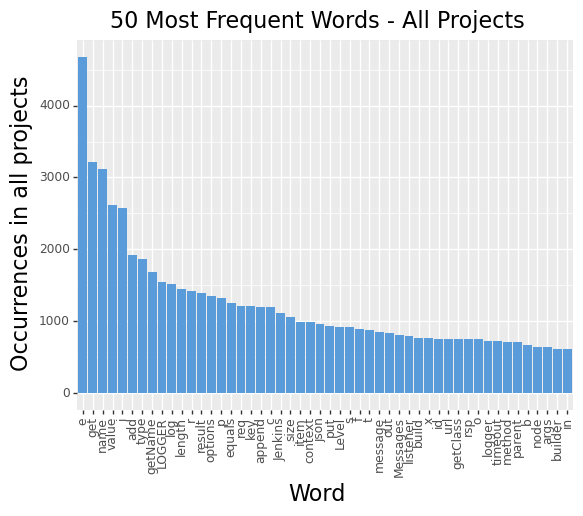

<ggplot: (122675943256)>


In [10]:
n = 50
word_occurrences_df = df.groupby([name_col, length_col])\
    .size()\
    .reset_index(name=count_col)\
    .sort_values(count_col, ascending=False)
word_occurrences_hist_df = word_occurrences_df.nlargest(n, count_col)

print(
	ggplot(word_occurrences_hist_df)
	+ labs(x="Word",
		   y="Occurrences in all projects",
		   title=str(n) + " Most Frequent Words - All Projects")
	+ scale_x_discrete(limits=word_occurrences_hist_df[name_col].tolist())
	+ geom_bar(aes(x=name_col, y=count_col), fill=fill, stat='identity')
	+ theme(axis_text_x=element_text(rotation=90), title=element_text(size=font_size))
)

### Zipf's Law - Words rank / frequency in log scale:


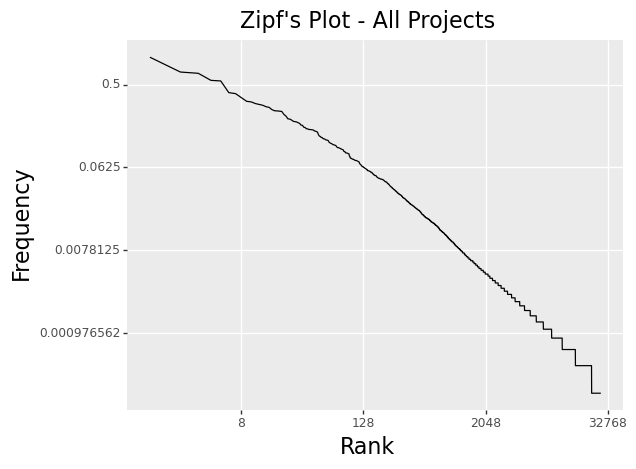

<ggplot: (122675361786)>


In [11]:
most_frequent_word_count = int(word_occurrences_df[:1][count_col])

# Add new normalized "frequency" column
word_occurrences_df[freq_col] = word_occurrences_df[count_col] / most_frequent_word_count
word_occurrences_df_length = word_occurrences_df.shape[0]
word_occurrences_df[rank_col] = np.linspace(1, word_occurrences_df_length, word_occurrences_df_length)

print(
    ggplot(word_occurrences_df)
    + labs(x="Rank",
           y="Frequency",
           title="Zipf's Plot - All Projects")
    + scale_x_continuous(trans='log2')
    + scale_y_continuous(trans='log2')
    + geom_line(aes(x=rank_col, y=freq_col), stat='identity')
    + theme(title=element_text(size=font_size))
)



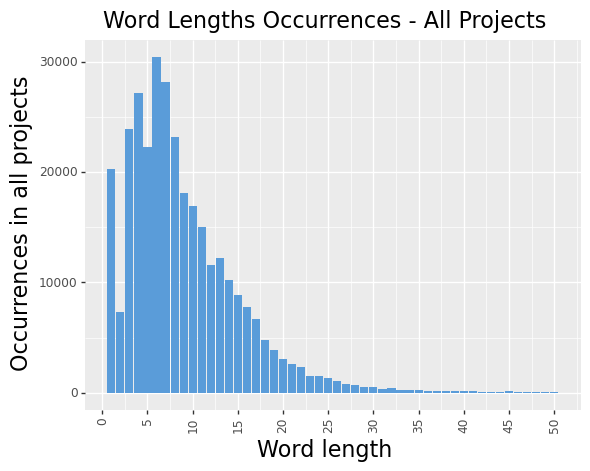

<ggplot: (122675668167)>


In [12]:
n = 50
length_occurrences_df = df.groupby([length_col]).size().reset_index(name=count_col)
length_occurrences_hist_df = length_occurrences_df.nsmallest(n, length_col)

print(
	ggplot(length_occurrences_hist_df)
	+ labs(x="Word length",
		   y="Occurrences in all projects",
		   title="Word Lengths Occurrences - All Projects")
	+ scale_x_continuous(breaks=range(0,51,5))
	+ geom_bar(aes(x=length_col, y=count_col), fill=fill, stat='identity')
	+ theme(axis_text_x=element_text(rotation=90), title=element_text(size=font_size))
)

## Longest word:

In [13]:
print("Length of longest word: " + str(length_occurrences_df[length_col].max()))

Length of longest word: 75


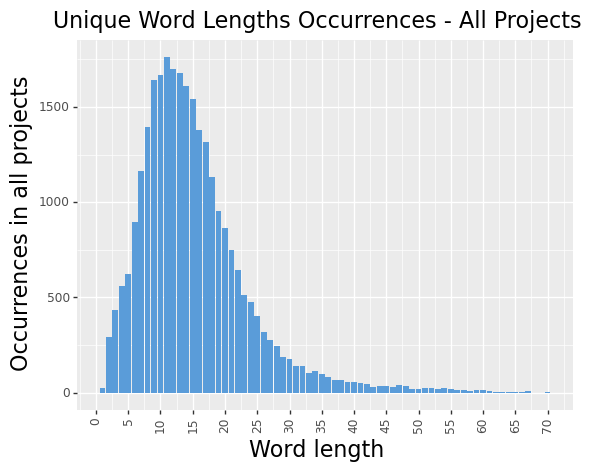

<ggplot: (122675593930)>


In [14]:
n = 70
length_occurrences_df = word_occurrences_df.groupby([length_col]).size().reset_index(name=count_col)
length_occurrences_hist_df = length_occurrences_df.nsmallest(n, length_col)

print(
	ggplot(length_occurrences_hist_df)
	+ labs(x="Word length",
		   y="Occurrences in all projects",
		   title="Unique Word Lengths Occurrences - All Projects")
	+ scale_x_continuous(breaks=range(0,71,5))
	+ geom_bar(aes(x=length_col, y=count_col), fill=fill, stat='identity')
	+ theme(axis_text_x=element_text(rotation=90), title=element_text(size=font_size))
)

### Add words rank per project

In [15]:
word_occurrences_per_project_df = df.groupby([name_col, length_col, project_col])\
    .size() \
    .reset_index(name=count_col) \
    .sort_values(count_col, ascending=False)

# Add rank column per project
# At the end of this process, we will have N rows in our dataframe with rank k,
# where N is the total number of project
projects = []
for project in word_occurrences_per_project_df[project_col].unique():
    project_df = word_occurrences_per_project_df[word_occurrences_per_project_df[project_col] == project]
    project_df.reset_index().sort_values(count_col, ascending=False)
    project_df_size = project_df.shape[0]
    project_df['project_rank'] = np.linspace(1, project_df_size, project_df_size)
    projects.append(project_df)

all_projects_df = pd.concat(projects)

# Calculate how many rank bins we'll need, cut the dataframe accordingly
bin_count = int(np.ceil(np.math.log(all_projects_df["project_rank"].max())))
all_projects_df["project_rank_bin"] = pd.cut(all_projects_df["project_rank"],
                                             bins=[0]+list(np.logspace(0, bin_count, bin_count+1)))

<ipython-input-15-747aced00e7e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  project_df['project_rank'] = np.linspace(1, project_df_size, project_df_size)


## Words' lengths by rank - per project breakdown

c:\users\alich\appdata\local\programs\python\python38\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_boxplot : Removed 1486 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


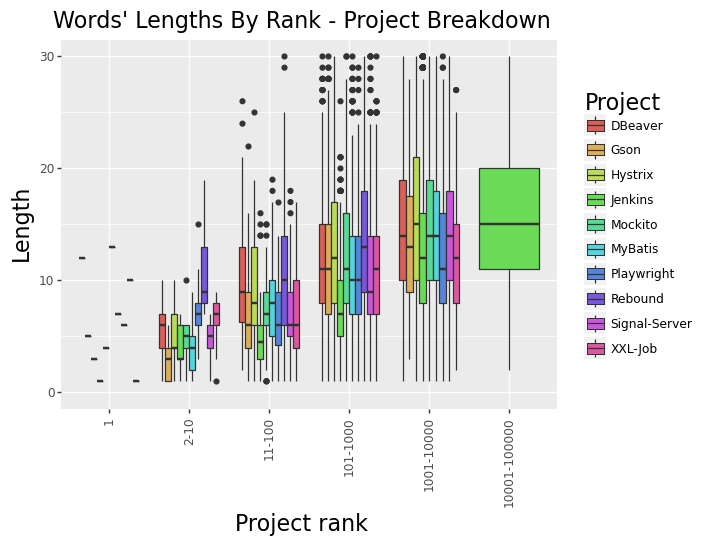

<ggplot: (122675770676)>


In [16]:
print(
    ggplot(all_projects_df)
    + labs(y="Length",
           x="Project rank",
           title="Words' Lengths By Rank - Project Breakdown",
           fill="Project")
    + geom_boxplot(aes(x='project_rank_bin', y=length_col, fill=project_col), position="dodge")
    + ylim(0, 30)
    + scale_x_discrete(limits=all_projects_df["project_rank_bin"].unique(), labels=log_x_scale_labels)
    + theme(axis_text_x=element_text(rotation=90), title=element_text(size=font_size))
      )

## Words' lengths by rank - all projects together

c:\users\alich\appdata\local\programs\python\python38\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_boxplot : Removed 1486 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


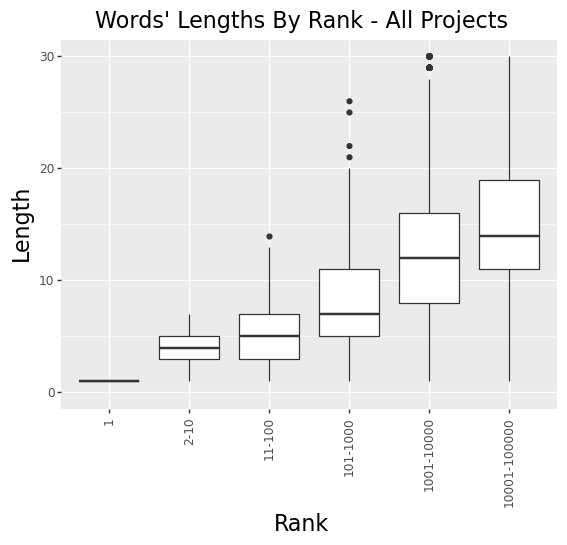

<ggplot: (122675871458)>


In [17]:
bin_count = int(np.ceil(np.math.log(word_occurrences_df.shape[0])))
word_occurrences_df["rank_bin"] = pd.cut(word_occurrences_df[rank_col], bins=[0]+list(np.logspace(0, bin_count, bin_count+1)))

print(ggplot(word_occurrences_df)
      + labs(y="Length",
             x="Rank",
             title="Words' Lengths By Rank - All Projects")
      + geom_boxplot(aes(x='rank_bin', y=length_col))
      + ylim(0, 30)
      + scale_x_discrete(labels=log_x_scale_labels)
      + theme(axis_text_x=element_text(rotation=90), title=element_text(size=font_size))
      )

## Compound Words - split and  count
### Define splitting function - by camelCase / PascalCase / snake_case:

In [18]:
def split_identifier_and_count(inpt):
	if inpt is None:
		return 0
	return len(re.findall(r'_?[A-Za-z_](?:[a-z0-9]+|[A-Z]*(?=[_A-Z]|$))', str(inpt)))

# Make sure the count is correct for different cases:
assert split_identifier_and_count("UUIDa") == 2
assert split_identifier_and_count("_hello") == 1
assert split_identifier_and_count("well_hello") == 2
assert split_identifier_and_count("howDoYouDo") == 4
assert split_identifier_and_count("HowDoYouDo") == 4
assert split_identifier_and_count("okTTYLbye") == 3
assert split_identifier_and_count("helloHello_HowDoYouDo") == 6
assert split_identifier_and_count("OY_LO_LAMA") == 3

### Split all names and add word count column:

In [19]:
word_occurrences_df[word_count_col] = word_occurrences_df[name_col]\
    .apply(split_identifier_and_count)\
    .astype('category')

word_occurrences_per_project_df = word_occurrences_per_project_df.merge(
    word_occurrences_df[[name_col, word_count_col]],
    on=name_col,
    how='left'
)


## Save dataframe as CSV data file:

In [20]:
word_occurrences_df.to_csv(abspath(join(base_dir, "word_occurrences_df.csv")), index=False)

## Identifiers' lengths frequency with word count breakdown for all project combined:

c:\users\alich\appdata\local\programs\python\python38\lib\site-packages\plotnine\layer.py:433: PlotnineWarning: position_stack : Removed 220 rows containing missing values.
  data = self.position.setup_data(self.data, params)
c:\users\alich\appdata\local\programs\python\python38\lib\site-packages\plotnine\layer.py:452: PlotnineWarning: geom_bar : Removed 21 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


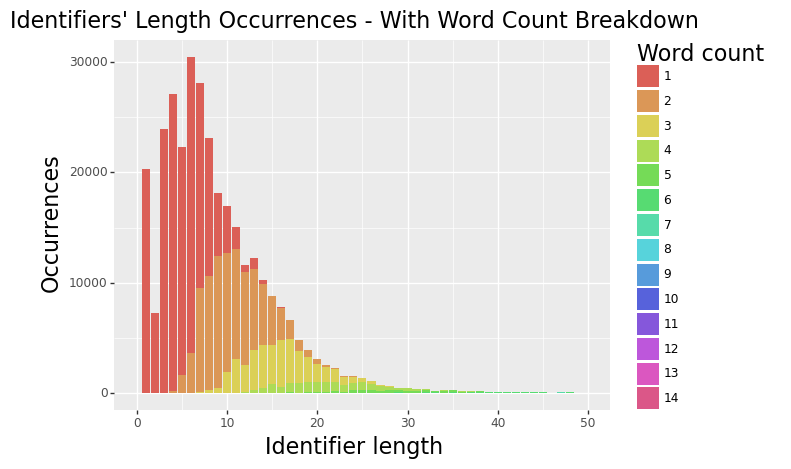

<ggplot: (122675781873)>


In [21]:
print(
	ggplot(word_occurrences_df)
	+ labs(x="Identifier length",
		   y="Occurrences",
		   title="Identifiers' Length Occurrences - With Word Count Breakdown",
           fill="Word count")
    + geom_bar(aes(x=length_col, y=count_col, fill=word_count_col), stat='identity')
  	+ xlim(0, 50)
    + theme(title=element_text(size=font_size))
)

## Identifiers lengths frequency, with word count breakdown - per project:

c:\users\alich\appdata\local\programs\python\python38\lib\site-packages\plotnine\layer.py:433: PlotnineWarning: position_stack : Removed 220 rows containing missing values.
  data = self.position.setup_data(self.data, params)
c:\users\alich\appdata\local\programs\python\python38\lib\site-packages\plotnine\layer.py:452: PlotnineWarning: geom_bar : Removed 21 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


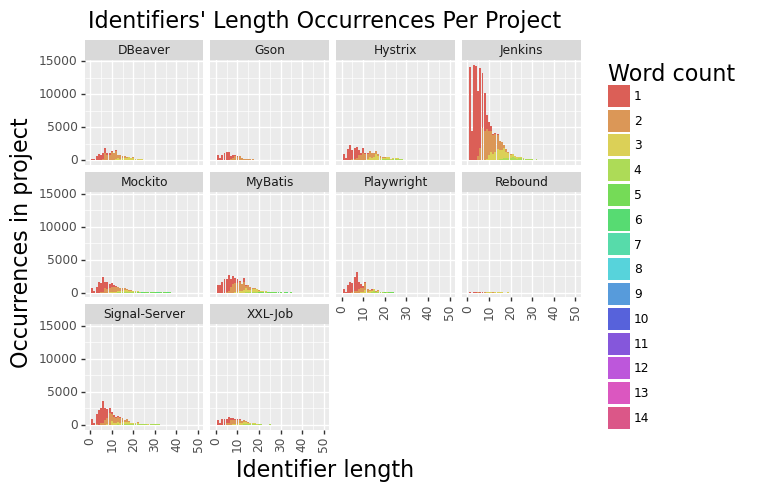

<ggplot: (122675646272)>


In [22]:
print(
	ggplot(word_occurrences_per_project_df)
	+ labs(x="Identifier length",
		   y="Occurrences in project",
		   title="Identifiers' Length Occurrences Per Project",
           fill="Word count")
    + geom_bar(aes(x=length_col, y=count_col, fill=word_count_col), stat='identity')
  	+ xlim(0, 50)
	+ facet_wrap(project_col)
	+ theme(axis_text_x=element_text(rotation=90), title=element_text(size=font_size))
)



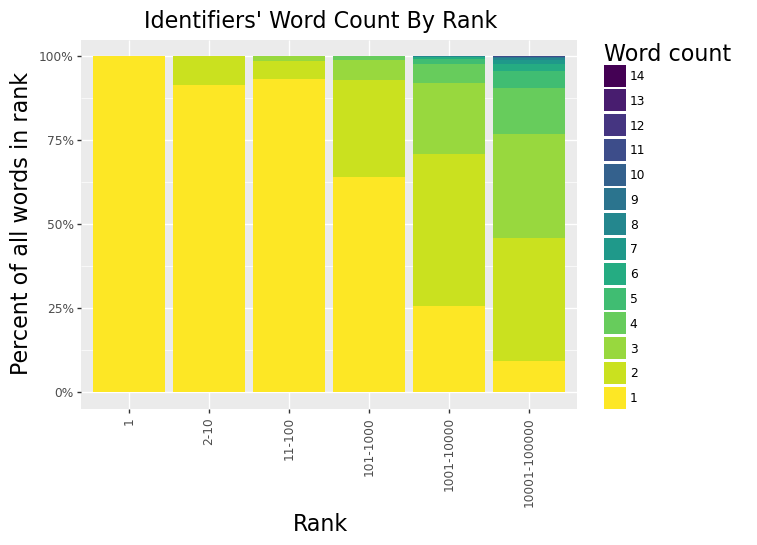

<ggplot: (122675875298)>


In [23]:
word_occurrences_df[word_count_col] = pd.Categorical(word_occurrences_df[word_count_col],
                                             categories=list(range(14, 0, -1)),
                                             ordered=True)

most_frequent_word_occurrences = int(word_occurrences_df[:1][count_col])
data_length = word_occurrences_df.shape[0]
word_occurrences_df[freq_col] = word_occurrences_df[count_col] / most_frequent_word_occurrences
word_occurrences_df[rank_col] = np.linspace(1, data_length, data_length)

bin_count = int(np.ceil(np.math.log(word_occurrences_df.shape[0])))
word_occurrences_df["rank_bin"] = pd.cut(word_occurrences_df[rank_col],
									bins=[0] + list(np.logspace(0, bin_count, bin_count + 1)))

print(
    ggplot(word_occurrences_df)
    + labs(x="Rank",
		   y="Percent of all words in rank",
		   title="Identifiers' Word Count By Rank",
           fill="Word count")
    + geom_bar(aes(x='rank_bin', y=count_col, fill=word_count_col), stat='identity', position="fill")
    + scale_y_continuous(labels=percent_format())
    + scale_x_discrete(labels=log_x_scale_labels)
    + theme(axis_text_x=element_text(rotation=90), title=element_text(size=font_size))
)

# Regenerating all the graphs after splitting compound words
## Setup splitting function:

In [24]:

split_words_count = np.zeros(word_occurrences_df.shape[0])
def split_identifier_and_append_to_df(inpt):
    if inpt is None:
        return 0
    parts = re.findall(r'_?[A-Za-z_](?:[a-z0-9]+|[A-Z]*(?=[_A-Z]|$))', str(inpt))
    if len(parts) > 1:
        split_words_count[word_occurrences_df[word_occurrences_df[name_col] == inpt].index] += 1
        for part in parts:
            plain_part = part.lower().replace("_", "")
            if plain_part in split_words:
                split_words[plain_part] += 1
            else:
                split_words[plain_part] = 1

split_words = {}
word_occurrences_df[name_col].apply(split_identifier_and_append_to_df)
split_words_df = pd.DataFrame(split_words.items(), columns=[name_col, count_col])

Words + count that will be added to original data:

In [25]:
print(split_words_df)

           name  count
0           get   3413
1          name    797
2         class    353
3        logger     43
4            is    862
...         ...    ...
4205      unpin      1
4206      c2396      1
4207        hot      1
4208  privilege      1
4209   loadable      1

[4210 rows x 2 columns]


In [26]:
word_occurrences_df_count_fixed = word_occurrences_df[:]
word_occurrences_df_count_fixed = word_occurrences_df_count_fixed[split_words_count == 0]
word_occurrences_df_count_fixed = word_occurrences_df_count_fixed[word_occurrences_df_count_fixed[count_col] > 0]
split_words_df[length_col] = split_words_df[name_col].str.len()
split_words_df = pd.concat([word_occurrences_df_count_fixed, split_words_df]).groupby([name_col, length_col])[count_col]\
    .sum()\
    .reset_index()\
    .sort_values(count_col, ascending=False)

Data after adding split words:

In [27]:
print(split_words_df)

               name  length  count
3415            get       3   3413
7615          value       5   2917
4191              i       1   2602
1164            add       3   2182
4840            log       3   1760
...             ...     ...    ...
2205         copies       6      1
5699   preallocated      12      1
5701     precedence      10      1
5702  preconditions      13      1
7915         zscore       6      1

[7916 rows x 3 columns]


### Words frequencies - Zipf's plot:

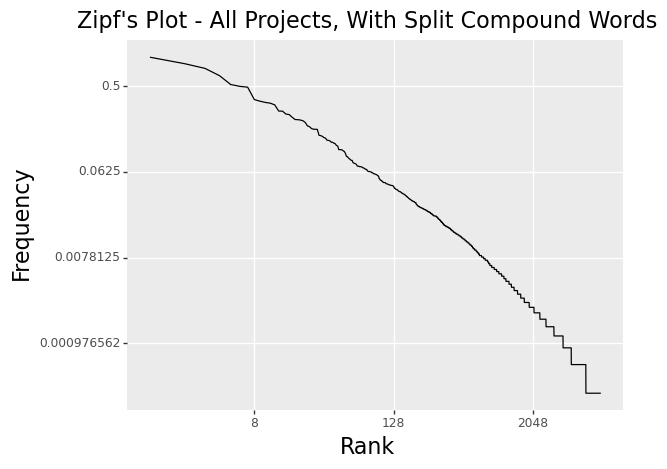

<ggplot: (122676461337)>


In [28]:
split_words_df[freq_col] = split_words_df[count_col] / int(split_words_df[:1][count_col])
split_words_df_length = split_words_df.shape[0]
split_words_df[rank_col] = np.linspace(1, split_words_df_length, split_words_df_length)

print(
    ggplot(split_words_df)
    + labs(x="Rank",
           y="Frequency",
           title="Zipf's Plot - All Projects, With Split Compound Words")
    + scale_x_continuous(trans='log2')
    + scale_y_continuous(trans='log2')
    + geom_line(aes(x=rank_col, y=freq_col), stat='identity')
    + theme(title=element_text(size=font_size))
)


### Words lengths occurrences:

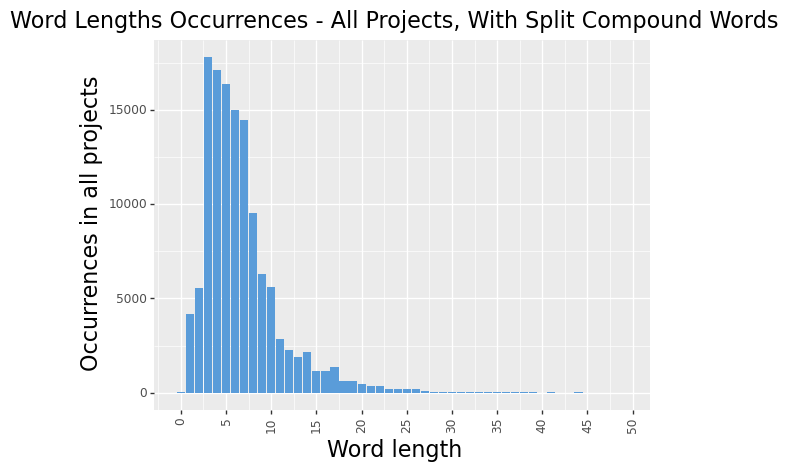

<ggplot: (122675870332)>


In [29]:
n = 50
length_occurrences_hist_df_with_split_words = split_words_df.groupby(length_col)[count_col]\
    .sum()\
    .reset_index()\
    .nsmallest(n, length_col)

print(
	ggplot(length_occurrences_hist_df_with_split_words)
	+ labs(x="Word length",
		   y="Occurrences in all projects",
		   title="Word Lengths Occurrences - All Projects, With Split Compound Words")
    + scale_x_continuous(breaks=range(0,n+1,5))
	+ geom_bar(aes(x=length_col, y=count_col), fill=fill, stat='identity')
	+ theme(axis_text_x=element_text(rotation=90), title=element_text(size=font_size))
)

### Words' lengths by rank - all projects together:

c:\users\alich\appdata\local\programs\python\python38\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_boxplot : Removed 210 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


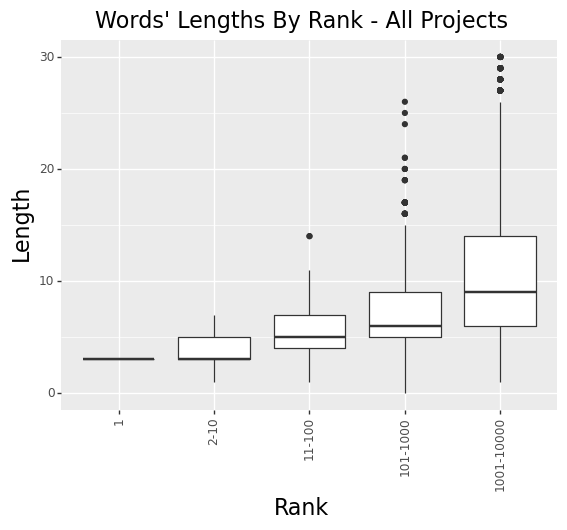

<ggplot: (122676453235)>


In [30]:
split_bin_count = int(np.ceil(np.math.log(split_words_df.shape[0])))
split_words_df["rank_bin"] = pd.cut(split_words_df[rank_col],
                                         bins=[0]+list(np.logspace(0, split_bin_count, split_bin_count+1)))

print(ggplot(split_words_df)
      + labs(y="Length",
             x="Rank",
             title="Words' Lengths By Rank - All Projects")
      + geom_boxplot(aes(x='rank_bin', y=length_col))
      + ylim(0, 30)
      + scale_x_discrete(labels=log_x_scale_labels)
      + theme(axis_text_x=element_text(rotation=90), title=element_text(size=font_size))
      )



## Save dataframe as CSV data file:

In [31]:
split_words_df.to_csv(abspath(join(base_dir, "word_occurrences_df_with_split_words.csv")),
                           index=False)